<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Setup

In [ ]:
%%capture
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
# import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle
from google.colab import files

import matplotlib.pyplot as plt
import statistics

In [ ]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [ ]:
torch.set_grad_enabled(False)

# Load Model

In [ ]:
from transformers import LlamaForCausalLM, LlamaTokenizer

In [ ]:
LLAMA_2_7B_CHAT_PATH = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH)
# tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH, use_fast= False, add_prefix_space= False)
hf_model = LlamaForCausalLM.from_pretrained(LLAMA_2_7B_CHAT_PATH, low_cpu_mem_usage=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import HookedTransformer

In [ ]:
model = HookedTransformer.from_pretrained(
    LLAMA_2_7B_CHAT_PATH,
    hf_model = hf_model,
    tokenizer = tokenizer,
    device = "cpu",
    fold_ln = False,
    center_writing_weights = False,
    center_unembed = False,
)

del hf_model

model = model.to("cuda" if torch.cuda.is_available() else "cpu")

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Moving model to device:  cuda


# Import functions from repo

In [ ]:
!git clone https://github.com/apartresearch/seqcont_circuits.git
%cd /content/seqcont_circuits/src/iter_node_pruning

Cloning into 'seqcont_circuits'...
remote: Enumerating objects: 1069, done.
remote: Counting objects: 100% (535/535), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 1069 (delta 336), reused 403 (delta 212), pack-reused 534 (from 1)
Receiving objects: 100% (1069/1069), 19.61 MiB | 27.25 MiB/s, done.
Resolving deltas: 100% (699/699), done.
/content/seqcont_circuits/src/iter_node_pruning


In [ ]:
# from dataset import Dataset
from metrics import *
from head_ablation_fns import *
from mlp_ablation_fns import *
from node_ablation_fns import *
from loop_node_ablation_fns import *

# Generate dataset with multiple prompts

In [ ]:
class Dataset:
    def __init__(self, prompts, tokenizer):  # , S1_is_first=False
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.corr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["corr"])[-1] for prompt in self.prompts
        ]
        self.incorr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["incorr"])[-1] for prompt in self.prompts
        ]

        pos_dict = {}
        list_tokens = tokenizer.tokenize((prompts[0]["text"]))
        for i, tok_as_str in enumerate(list_tokens):
            pos_dict['S'+str(i)] = i

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        # for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
        for targ in [key for key in pos_dict]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = self.tokenizer.tokenize(input_text)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

In [ ]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'corr': str(i+4),
            'incorr': str(i+3),
            'text': f"{i} {i+1} {i+2} {i+3} "
        }
        list_tokens = tokenizer.tokenize(prompt_dict['text'])
        for i, tok_as_str in enumerate(list_tokens):
            # if tok_as_str == '▁':
            #     prompt_dict['S'+str(i)] = ' '
            # else:
            #     prompt_dict['S'+str(i)] = tok_as_str
            prompt_dict['S'+str(i)] = tok_as_str
        prompts_list.append(prompt_dict)
    return prompts_list

# prompts_list = generate_prompts_list(1, 9)
prompts_list = generate_prompts_list(1, 6)
prompts_list

[{'corr': '5',
  'incorr': '4',
  'text': '1 2 3 4 ',
  'S0': '▁',
  'S1': '1',
  'S2': '▁',
  'S3': '2',
  'S4': '▁',
  'S5': '3',
  'S6': '▁',
  'S7': '4',
  'S8': '▁'},
 {'corr': '6',
  'incorr': '5',
  'text': '2 3 4 5 ',
  'S0': '▁',
  'S1': '2',
  'S2': '▁',
  'S3': '3',
  'S4': '▁',
  'S5': '4',
  'S6': '▁',
  'S7': '5',
  'S8': '▁'},
 {'corr': '7',
  'incorr': '6',
  'text': '3 4 5 6 ',
  'S0': '▁',
  'S1': '3',
  'S2': '▁',
  'S3': '4',
  'S4': '▁',
  'S5': '5',
  'S6': '▁',
  'S7': '6',
  'S8': '▁'},
 {'corr': '8',
  'incorr': '7',
  'text': '4 5 6 7 ',
  'S0': '▁',
  'S1': '4',
  'S2': '▁',
  'S3': '5',
  'S4': '▁',
  'S5': '6',
  'S6': '▁',
  'S7': '7',
  'S8': '▁'},
 {'corr': '9',
  'incorr': '8',
  'text': '5 6 7 8 ',
  'S0': '▁',
  'S1': '5',
  'S2': '▁',
  'S3': '6',
  'S4': '▁',
  'S5': '7',
  'S6': '▁',
  'S7': '8',
  'S8': '▁'}]

In [ ]:
import random

def generate_prompts_list_corr(prompt_list):
    outlist = []
    for prompt_dict in prompts_list:
        r1 = random.randint(1, 9)
        r2 = random.randint(1, 9)
        while True:
            r3 = random.randint(1, 9)
            r4 = random.randint(1, 9)
            if r4 - 1 != r3:
                break
        new_prompt_dict = {
            'corr': prompt_dict['corr'],
            'incorr': prompt_dict['incorr'],
            'text': f"{r1} {r2} {r3} {r4} "
        }
        list_tokens = tokenizer.tokenize(new_prompt_dict['text'])
        for i, tok_as_str in enumerate(list_tokens):
            # if tok_as_str == '▁':
            #     prompt_dict['S'+str(i)] = ' '
            # else:
            #     prompt_dict['S'+str(i)] = tok_as_str
            new_prompt_dict['S'+str(i)] = tok_as_str
        outlist.append(new_prompt_dict)
    return outlist
prompts_list_2 = generate_prompts_list_corr(prompts_list)
prompts_list_2

[{'corr': '5',
  'incorr': '4',
  'text': '7 9 6 1 ',
  'S0': '▁',
  'S1': '7',
  'S2': '▁',
  'S3': '9',
  'S4': '▁',
  'S5': '6',
  'S6': '▁',
  'S7': '1',
  'S8': '▁'},
 {'corr': '6',
  'incorr': '5',
  'text': '2 7 6 9 ',
  'S0': '▁',
  'S1': '2',
  'S2': '▁',
  'S3': '7',
  'S4': '▁',
  'S5': '6',
  'S6': '▁',
  'S7': '9',
  'S8': '▁'},
 {'corr': '7',
  'incorr': '6',
  'text': '9 9 3 5 ',
  'S0': '▁',
  'S1': '9',
  'S2': '▁',
  'S3': '9',
  'S4': '▁',
  'S5': '3',
  'S6': '▁',
  'S7': '5',
  'S8': '▁'},
 {'corr': '8',
  'incorr': '7',
  'text': '6 6 1 8 ',
  'S0': '▁',
  'S1': '6',
  'S2': '▁',
  'S3': '6',
  'S4': '▁',
  'S5': '1',
  'S6': '▁',
  'S7': '8',
  'S8': '▁'},
 {'corr': '9',
  'incorr': '8',
  'text': '3 1 1 4 ',
  'S0': '▁',
  'S1': '3',
  'S2': '▁',
  'S3': '1',
  'S4': '▁',
  'S5': '1',
  'S6': '▁',
  'S7': '4',
  'S8': '▁'}]

In [ ]:
dataset = Dataset(prompts_list, model.tokenizer)
dataset_2 = Dataset(prompts_list_2, model.tokenizer)

# Get orig score

In [ ]:
model.reset_hooks(including_permanent=True)
logits_original = model(dataset.toks)
orig_score = get_logit_diff(logits_original, dataset)

In [ ]:
next_token = logits_original[0, -1].argmax(dim=-1)  # logits have shape [1, sequence_length, vocab_size]
next_char = model.to_string(next_token)
print(repr(next_char))

'5'


In [ ]:
orig_score

tensor(2.9110, device='cuda:0')

In [ ]:
import gc

del(logits_original)
torch.cuda.empty_cache()
gc.collect()

21

# Find Impt Attention Heads from Full

## test unablated run

Llama-2 has 32 heads per layer

In [ ]:
lst = [(layer, head) for layer in range(32) for head in range(0, 32)]
CIRCUIT = {}
SEQ_POS_TO_KEEP = {}

list_tokens = tokenizer.tokenize(dataset.prompts[0]['text'])
for i, tok_as_str in enumerate(list_tokens):
    CIRCUIT['S'+str(i)] = lst
    if i == len(list_tokens) - 1:
        SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
    else:
        SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
SEQ_POS_TO_KEEP

{'S0': 'S0', 'S1': 'S1', 'S2': 'S2', 'S3': 'end'}

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

# clean_text = "12 14 16"
# corr_text = "15 12 17"
# heads_not_ablate = []  # ablate all heads but not MLPs
# mlps_not_ablate = []  # ablate all MLPs
# # ablated_score = ablate_then_gen(model, clean_text, corr_text, heads_not_ablate, mlps_not_ablate, corr_ans_tokLen)

# ablated_score = ablate_then_gen(model, dataset.toks, dataset_2.toks, heads_not_ablate, mlps_not_ablate, corr_ans_tokLen)

model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
logits_minimal = model(dataset.toks)

new_score = get_logit_diff(logits_minimal, dataset)

In [ ]:
next_token = logits_minimal[0, -1].argmax(dim=-1)  # logits have shape [1, sequence_length, vocab_size]
next_char = model.to_string(next_token)
print(repr(next_char))

'0'


In [ ]:
print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
new_score

Average logit difference (circuit / full) %: 100.0000


tensor(-6.5058, device='cuda:0')

In [ ]:
import gc

del(logits_minimal)
torch.cuda.empty_cache()
gc.collect()

0

## run each

In [ ]:
def ablate_head_from_full(
        lst: List[Tuple[int, int]],
        model: HookedTransformer,
        dataset: Dataset,
        dataset_2: Dataset,
        orig_score: float,
        print_output: bool = True,
) -> float:
    # CIRCUIT contains the components to not ablate
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}

    list_tokens = tokenizer.tokenize('1 2 3 4')
    for i, tok_as_str in enumerate(list_tokens):
        CIRCUIT['S'+str(i)] = lst
        SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
        if i == 7:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    logits_minimal = model(dataset.toks)

    new_score = get_logit_diff(logits_minimal, dataset)
    if print_output:
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    return 100 * new_score / orig_score

In [ ]:
circ = [(layer, head) for layer in range(32) for head in range(0, 32)]
# to_loop = circ.copy() # (L,H) to remove
to_loop = [(layer, head) for layer in range(32) for head in range(0, 32)]

lh_scores = {}
for lh in to_loop:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = ablate_head_from_full(copy_circuit, model, dataset, dataset_2, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 0)
Average logit difference (circuit / full) %: 99.8669
removed: (0, 1)
Average logit difference (circuit / full) %: 100.6312
removed: (0, 2)
Average logit difference (circuit / full) %: 99.4772
removed: (0, 3)
Average logit difference (circuit / full) %: 100.8142
removed: (0, 4)
Average logit difference (circuit / full) %: 100.2262
removed: (0, 5)
Average logit difference (circuit / full) %: 100.0235
removed: (0, 6)
Average logit difference (circuit / full) %: 99.8446
removed: (0, 7)
Average logit difference (circuit / full) %: 99.8350
removed: (0, 8)
Average logit difference (circuit / full) %: 100.1723
removed: (0, 9)
Average logit difference (circuit / full) %: 99.8532
removed: (0, 10)
Average logit difference (circuit / full) %: 99.7288
removed: (0, 11)
Average logit difference (circuit / full) %: 99.9774
removed: (0, 12)
Average logit difference (circuit / full) %: 99.6268
removed: (0, 13)
Average logit difference (circuit / full) %: 98.8802
removed: (0, 14)
Average 

In [ ]:
# Sort the dictionary by values in descending order
sorted_lh_scores = sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True)

# Iterate over the top 10 items and print them
i=1
for lh, score in sorted_lh_scores[:50]:
    modified_score = -round(100 - score, 2)
    print(i, lh, modified_score)
    i+=1

1 (5, 25) -40.91
2 (20, 17) -26.49
3 (3, 24) -25.01
4 (16, 0) -13.68
5 (4, 3) -11.47
6 (8, 0) -10.76
7 (22, 25) -10.06
8 (6, 11) -9.64
9 (28, 5) -9.37
10 (8, 4) -9.2
11 (31, 4) -8.52
12 (30, 13) -8.06
13 (5, 15) -6.51
14 (30, 31) -5.54
15 (12, 2) -5.5
16 (12, 15) -5.23
17 (12, 22) -5.06
18 (10, 13) -5.01
19 (11, 28) -4.78
20 (14, 7) -4.75
21 (4, 16) -4.71
22 (29, 5) -4.44
23 (27, 31) -4.26
24 (16, 24) -3.99
25 (29, 30) -3.79
26 (28, 16) -3.49
27 (7, 30) -3.46
28 (5, 11) -3.42
29 (18, 26) -2.88
30 (9, 31) -2.87
31 (12, 23) -2.76
32 (18, 17) -2.59
33 (7, 0) -2.46
34 (8, 15) -2.39
35 (31, 11) -2.29
36 (29, 1) -2.28
37 (2, 4) -2.28
38 (5, 16) -2.17
39 (26, 30) -2.04
40 (22, 10) -1.92
41 (30, 24) -1.88
42 (31, 12) -1.86
43 (7, 21) -1.8
44 (25, 3) -1.79
45 (2, 24) -1.76
46 (14, 1) -1.67
47 (10, 6) -1.67
48 (31, 30) -1.64
49 (0, 25) -1.59
50 (18, 31) -1.57


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

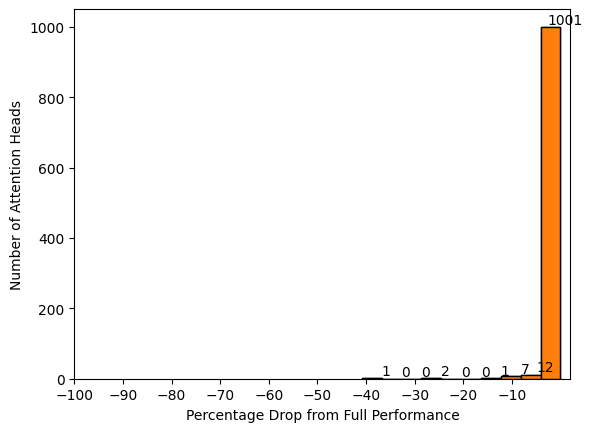

In [ ]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}
scores = list(lh_scores_drop.values())
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

plt.show()

In [ ]:
scores = list(lh_scores_drop.values())
mean_score = statistics.mean(scores)
print("Mean of the scores:", mean_score)

# with open('numerals_lh_scores.pkl', 'wb') as file:
#     pickle.dump(lh_scores, file)
#     files.download('numerals_lh_scores.pkl')

Mean of the scores: -0.4185224212706089


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Find Impt MLPs from Full

In [ ]:
for i in range(32):
    lst = [layer for layer in range(32) if layer != i]
    perc_of_orig = ablate_MLP_from_full(lst, model, dataset, dataset_2, orig_score, print_output=False).item()
    print(i, perc_of_orig)

0 68.39082336425781
1 60.9903564453125
2 67.35907745361328
3 76.4286880493164
4 74.830078125
5 83.50626373291016
6 76.4582290649414
7 73.5766372680664
8 94.43434143066406
9 101.66463470458984
10 82.34976196289062
11 100.44725036621094
12 107.74789428710938
13 106.05551147460938
14 103.30465698242188
15 76.74903106689453
16 93.27847290039062
17 100.48667907714844
18 88.48347473144531
19 93.16832733154297
20 87.30072784423828
21 97.45310974121094
22 96.55979919433594
23 99.94934844970703
24 94.39239501953125
25 103.35821533203125
26 99.5173110961914
27 92.53862762451172
28 87.70771026611328
29 85.92241668701172
30 104.64595031738281
31 72.6233139038086


# Node Ablation Iteration

## new fns

In [ ]:
# from dataset import Dataset
# from transformer_lens import HookedTransformer, utils
# from transformer_lens.hook_points import HookPoint
# import einops
# from functools import partial
# import torch as t
# from torch import Tensor
# from typing import Dict, Tuple, List
# from jaxtyping import Float, Bool

# from node_ablation_fns import *

# def find_circuit_forw(model, dataset, dataset_2, heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
#     # threshold is T, a %. if performance is less than T%, allow its removal
#     # we don't ablate the curr circuits
#     if heads_not_ablate == []: # Start with full circuit
#         heads_not_ablate = [(layer, head) for layer in range(12) for head in range(12)]
#     if mlps_not_ablate == []:
#         mlps_not_ablate = [layer for layer in range(12)]

#     comp_scores = {}
#     for layer in range(0, 12):
#         for head in range(12):
#             print(layer, head)
#             if (layer, head) not in heads_not_ablate:
#                 continue

#             copy_heads_not_ablate = heads_not_ablate.copy()
#             copy_heads_not_ablate.remove((layer, head))

#             model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#             ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

#             new_logits = ablated_model(dataset.toks)
#             new_score = get_logit_diff(new_logits, dataset)
#             new_perc = 100 * new_score / orig_score
#             comp_scores[layer] = new_perc
#             print(f"(cand circuit / full) %: {new_perc:.4f}")
#             if (100 - new_perc) < threshold:
#                 heads_not_ablate.remove((layer, head))
#                 print("Removed:", (layer, head))
#             del(new_logits)

#         print(layer)
#         if layer in mlps_not_ablate:
#             copy_mlps_not_ablate = mlps_not_ablate.copy()
#             copy_mlps_not_ablate.remove(layer)

#             model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#             ablated_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

#             new_logits = ablated_model(dataset.toks)
#             new_score = get_logit_diff(new_logits, dataset)
#             new_perc = 100 * new_score / orig_score
#             comp_scores[(layer, head)] = new_perc
#             print(f"(cand circuit / full) %: {new_perc:.4f}")
#             if (100 - new_perc) < threshold:
#                 mlps_not_ablate.remove(layer)
#                 print("Removed: MLP ", layer)
#             del(new_logits)

#     return heads_not_ablate, mlps_not_ablate, new_perc, comp_scores

def find_circuit_backw(model, dataset, dataset_2, heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    # we don't ablate the curr circuits
    if heads_not_ablate == []: # Start with full circuit
        heads_not_ablate = [(layer, head) for layer in range(32) for head in range(32)]
    if mlps_not_ablate == []:
        mlps_not_ablate = [layer for layer in range(32)]

    comp_scores = {}
    for layer in range(31, -1, -1):  # go thru all heads in a layer first
        print(layer)
        if layer in mlps_not_ablate:
            copy_mlps_not_ablate = mlps_not_ablate.copy()
            copy_mlps_not_ablate.remove(layer)

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = get_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[layer] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                mlps_not_ablate.remove(layer)
                print("Removed: MLP ", layer)
            del(new_logits)

        for head in range(32):
            print(layer, head)
            if (layer, head) not in heads_not_ablate:
                continue

            copy_heads_not_ablate = heads_not_ablate.copy()
            copy_heads_not_ablate.remove((layer, head))

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = get_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[(layer, head)] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                heads_not_ablate.remove((layer, head))
                print("Removed:", (layer, head))
            del(new_logits)

    return heads_not_ablate, mlps_not_ablate, new_score, comp_scores

## run

In [ ]:
# threshold = 20
# curr_circ_heads = []
# curr_circ_mlps = []
# prev_score = 100
# new_score = 0
# iter = 1
# all_comp_scores = []
# while prev_score != new_score:
#     print('\nbackw prune, iter ', str(iter))
#     old_circ_heads = curr_circ_heads.copy() # save old before finding new one
#     old_circ_mlps = curr_circ_mlps.copy()
#     curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
#     if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
#         break
#     all_comp_scores.append(comp_scores)
#     print('\nfwd prune, iter ', str(iter))
#     # track changes in circuit as for some reason it doesn't work with scores
#     old_circ_heads = curr_circ_heads.copy()
#     old_circ_mlps = curr_circ_mlps.copy()
#     curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_forw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
#     if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
#         break
#     all_comp_scores.append(comp_scores)
#     iter += 1

In [ ]:
threshold = 20
curr_circ_heads = []
curr_circ_mlps = []
prev_score = 100
new_score = 0
iter = 1
all_comp_scores = []
# while prev_score != new_score:
# print('\nbackw prune, iter ', str(iter))
old_circ_heads = curr_circ_heads.copy() # save old before finding new one
old_circ_mlps = curr_circ_mlps.copy()
curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)

31
(cand circuit / full) %: 85.9981
Removed: MLP  31
31 0
(cand circuit / full) %: 86.0244
Removed: (31, 0)
31 1
(cand circuit / full) %: 86.0315
Removed: (31, 1)
31 2
(cand circuit / full) %: 86.0173
Removed: (31, 2)
31 3
(cand circuit / full) %: 86.0034
Removed: (31, 3)
31 4
(cand circuit / full) %: 85.7788
Removed: (31, 4)
31 5
(cand circuit / full) %: 85.6153
Removed: (31, 5)
31 6
(cand circuit / full) %: 85.7229
Removed: (31, 6)
31 7
(cand circuit / full) %: 85.7288
Removed: (31, 7)
31 8
(cand circuit / full) %: 84.9922
Removed: (31, 8)
31 9
(cand circuit / full) %: 84.9829
Removed: (31, 9)
31 10
(cand circuit / full) %: 85.1515
Removed: (31, 10)
31 11
(cand circuit / full) %: 84.9953
Removed: (31, 11)
31 12
(cand circuit / full) %: 85.0004
Removed: (31, 12)
31 13
(cand circuit / full) %: 85.0597
Removed: (31, 13)
31 14
(cand circuit / full) %: 84.8954
Removed: (31, 14)
31 15
(cand circuit / full) %: 84.7029
Removed: (31, 15)
31 16
(cand circuit / full) %: 84.6750
Removed: (31, 16

In [ ]:
with open('numwords_b_20_scores.pkl', 'wb') as file:
    pickle.dump(all_comp_scores, file)
files.download('numwords_b_20_scores.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
curr_circ_heads

[(0, 2),
 (0, 5),
 (0, 6),
 (0, 15),
 (1, 15),
 (1, 28),
 (2, 13),
 (2, 24),
 (3, 24),
 (4, 3),
 (4, 16),
 (5, 11),
 (5, 13),
 (5, 15),
 (5, 16),
 (5, 23),
 (5, 25),
 (5, 27),
 (6, 11),
 (6, 14),
 (6, 20),
 (6, 23),
 (6, 24),
 (6, 26),
 (6, 28),
 (6, 30),
 (6, 31),
 (7, 0),
 (7, 13),
 (7, 21),
 (7, 30),
 (8, 0),
 (8, 2),
 (8, 12),
 (8, 15),
 (8, 26),
 (8, 27),
 (8, 30),
 (8, 31),
 (9, 15),
 (9, 16),
 (9, 23),
 (9, 26),
 (9, 27),
 (9, 29),
 (9, 31),
 (10, 1),
 (10, 13),
 (10, 18),
 (10, 23),
 (10, 29),
 (11, 7),
 (11, 8),
 (11, 9),
 (11, 17),
 (11, 18),
 (11, 25),
 (11, 28),
 (12, 18),
 (12, 19),
 (12, 23),
 (12, 27),
 (13, 6),
 (13, 11),
 (13, 20),
 (14, 18),
 (14, 19),
 (14, 20),
 (14, 21),
 (16, 0),
 (18, 19),
 (18, 21),
 (18, 25),
 (18, 26),
 (18, 31),
 (19, 28),
 (20, 17),
 (21, 0),
 (21, 2),
 (22, 18),
 (22, 20),
 (22, 25),
 (23, 27),
 (26, 2)]

In [ ]:
curr_circ_mlps

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 20,
 21,
 24,
 25,
 27,
 28,
 29,
 30]

## Find most impt heads from circ

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, curr_circ_heads, curr_circ_mlps)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 57.4160


In [ ]:
lh_scores = {}
for lh in curr_circ_heads:
    copy_circuit = curr_circ_heads.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    model = add_ablation_hook_MLP_head(model, dataset_2, copy_circuit, curr_circ_mlps)

    new_logits = model(dataset.toks)
    new_score = get_logit_diff(new_logits, dataset).item()
    new_perc = 100 * new_score / orig_score
    print(f"(cand circuit / full) %: {new_perc:.4f}")
    lh_scores[lh] = new_perc

removed: (0, 2)
(cand circuit / full) %: 56.8762
removed: (0, 5)
(cand circuit / full) %: 57.0452
removed: (0, 6)
(cand circuit / full) %: 56.9930
removed: (0, 15)
(cand circuit / full) %: 55.6610
removed: (1, 15)
(cand circuit / full) %: 54.9548
removed: (1, 28)
(cand circuit / full) %: 56.1419
removed: (2, 13)
(cand circuit / full) %: 56.8731
removed: (2, 24)
(cand circuit / full) %: 54.4502
removed: (3, 24)
(cand circuit / full) %: 24.8077
removed: (4, 3)
(cand circuit / full) %: 35.3327
removed: (4, 16)
(cand circuit / full) %: 49.4831
removed: (5, 11)
(cand circuit / full) %: 55.8051
removed: (5, 13)
(cand circuit / full) %: 57.3040
removed: (5, 15)
(cand circuit / full) %: 54.5836
removed: (5, 16)
(cand circuit / full) %: 55.9894
removed: (5, 23)
(cand circuit / full) %: 57.2644
removed: (5, 25)
(cand circuit / full) %: 28.1754
removed: (5, 27)
(cand circuit / full) %: 56.9895
removed: (6, 11)
(cand circuit / full) %: 47.0191
removed: (6, 14)
(cand circuit / full) %: 54.5060
remo

In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score.item(), 2))

(20, 17) -56.78
(3, 24) -32.61
(5, 25) -29.24
(16, 0) -27.02
(4, 3) -22.08
(6, 11) -10.4
(12, 18) -10.26
(18, 19) -10.11
(8, 0) -10.04
(4, 16) -7.93
(7, 30) -7.58
(9, 31) -5.2
(13, 20) -5.14
(23, 27) -4.34
(7, 0) -4.16
(11, 28) -3.99
(22, 25) -3.26
(2, 24) -2.97
(6, 14) -2.91
(5, 15) -2.83
(18, 31) -2.83
(6, 26) -2.81
(1, 15) -2.46
(6, 24) -2.18
(8, 15) -2.14
(13, 6) -1.92
(0, 15) -1.76
(10, 13) -1.71
(12, 23) -1.66
(5, 11) -1.61
(12, 27) -1.58
(6, 31) -1.52
(11, 8) -1.46
(5, 16) -1.43
(11, 25) -1.34
(11, 18) -1.32
(1, 28) -1.27
(7, 21) -1.19
(18, 21) -1.03
(8, 27) -0.86
(8, 2) -0.81
(10, 1) -0.78
(14, 19) -0.72
(18, 26) -0.6
(18, 25) -0.58
(2, 13) -0.54
(0, 2) -0.54
(11, 17) -0.49
(9, 23) -0.48
(6, 20) -0.44
(5, 27) -0.43
(0, 6) -0.42
(11, 7) -0.38
(0, 5) -0.37
(10, 29) -0.37
(9, 16) -0.37
(10, 23) -0.34
(8, 30) -0.3
(19, 28) -0.26
(9, 26) -0.16
(14, 21) -0.15
(5, 23) -0.15
(6, 30) -0.13
(6, 28) -0.12
(5, 13) -0.11
(14, 18) -0.1
(8, 31) -0.07
(7, 13) -0.07
(6, 23) -0.07
(8, 12) -0.03
